# Run ecRad with CAMS input data
The cams data is downloaded as grib and converted to nc with:
https://gitea.tropos.de/walther/retrieve_convert_camsra_camsfc
in this example nc files are merged to monthly files instead of daily files

The CAMS data is stored in two files surface parameters (sfc) and model level profile data (ml).
Both files are required to produce the ecRad input file.

Also ecrad is required obviously: https://github.com/ecmwf/ecrad

Below the workflow from cams datafiles to an ecRad run is shown:

In [1]:
# imports
import os
import datetime as dt
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# custom modules
import camsra2ecrad as c2e
import run_ecrad as re
# 
from CAMS_aerosol_props import load_cams_data as cams

# config
date = dt.date(2020,1,1) # day required

# paths
pf = "example_data"
ncfile_path = "example_data/nc"
infile_path = "example_data/ecrad_input"
output_path = "example_data/ecrad_output"

# path to ecrad installation
# https://github.com/ecmwf/ecrad
ecrad_path = ecpf = "/home/walther/programms/ecrad-1.3.0"
# aerosol optical properties of cams aerosol
# https://doi.org/10.24380/jgs8-sc58
# have to be stored in <ecrad_path>/data/
aerosol_props = "aerosol_cams_ifs_optics.nc"

# filename templates
infile_fname = "input_{date:%Y-%m}.nc"
outfile_fname = "output_{date:%Y-%m}.nc"
camsra_fname = "cams-fc_{date:%Y-%m}_punta_{levtype}.nc"

In [2]:
# 1.step convert cams data to ECRAD input
c2e.prepare_ecrad_input(date = date,
                        ncpath = ncfile_path,
                        outpath = infile_path, # outpath means path to store the produced input files
                        sorce_tsi_fname = "example_data/sorce_tsi_24hr_l3_full.csv", # sorce is used to define extraterestial radiation
                        outfile_fname_temp = infile_fname,
                        camsra_fname_temp = camsra_fname)

0

In [3]:
# 2. load ECRAD input file
INFILE = xr.open_dataset(os.path.join(infile_path,infile_fname.format(date=date)))
print(INFILE)

<xarray.Dataset>
Dimensions:                 (aerosol_type: 11, col: 2232, half_level: 138, level: 137, lw_emiss_band: 1, sw_albedo_band: 2)
Coordinates:
  * col                     (col) int64 0 1 2 3 4 5 ... 2227 2228 2229 2230 2231
  * half_level              (half_level) int64 0 1 2 3 4 ... 133 134 135 136 137
  * level                   (level) int64 0 1 2 3 4 5 ... 132 133 134 135 136
  * aerosol_type            (aerosol_type) int64 0 1 2 3 4 5 6 7 8 9 10
  * sw_albedo_band          (sw_albedo_band) int64 0 1
  * lw_emiss_band           (lw_emiss_band) int64 0
Data variables:
    solar_irradiance        float64 ...
    skin_temperature        (col) float32 ...
    cos_solar_zenith_angle  (col) float64 ...
    sw_albedo               (col, sw_albedo_band) float64 ...
    sw_albedo_direct        (col, sw_albedo_band) float64 ...
    lw_emissivity           (col, lw_emiss_band) float32 ...
    pressure_hl             (col, half_level) float64 ...
    temperature_hl          (col, ha

In [4]:
# 3. make namfile ( ecRad config )
namfile = re.make_namfile_str(ecrad_path = ecrad_path,
                              optpropfile = aerosol_props,
                              aerosol = True, # aerosol can be swiched on and off (True=with aerosol)
                              albedo = True,  # surface albedo can be swiched on and off
                              h2o_scale = 1,  # h2o,co2 and o3 can be scaled directly in ecRad
                              co2_scale = 1,
                              o3_scale = 1) 

print(namfile)


               &radiation_driver
                do_parallel              = true,   ! Use OpenMP parallelization?
                nblocksize               = 8,      ! Number of columns to process per thread
                do_save_inputs           = false,  ! Save inputs in "inputs.nc"?
                iverbose                 = 3,
                istartcol                = 0,      ! Use full range of columns by default
                iendcol                  = 0,
                nrepeat                  = 1,
                !
                ! Override Input
                h2o_scaling = 1,
                co2_scaling = 1,
                o3_scaling = 1,
                !sw_albedo = 0,
                /
                !
                &radiation
                ! General----------------------------------------------------------------------
                do_sw                   = true,           ! Compute shortwave fluxes?
                do_lw                   = true,          

In [5]:
# 4. run ECRAD 
# in the process temporary files for input, output and namfile will be created in the tmp folder 
OUTF = re.run_ecrad(inputfile=INFILE,
                    namfile=namfile,
                    outfile=os.path.join(output_path,outfile_fname.format(date=date)),
                    reduce_out=True, # reduced out will store only TOA and SFC fluxes
                    ecrad_path=os.path.join(ecrad_path,'bin/'), # "bin" extension is required as this path points to the ecrad executable
                    opt_prop_file=aerosol_props)

print(OUTF)

<xarray.Dataset>
Dimensions:                         (lat: 3, lon: 3, time: 248, wvl_lw: 16, wvl_sw: 13)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-01T03:00:00...
  * lat                             (lat) float64 -52.5 -53.0 -53.5
  * lon                             (lon) float64 -71.0 -70.5 -70.0
  * wvl_sw                          (wvl_sw) float32 3461.5386 ... 231.57895
  * wvl_lw                          (wvl_lw) float32 514285.72 ... 3461.5386
Data variables:
    flux_dn_sw_toa                  (time, lat, lon) float32 0.0 ... 107.61202
    flux_dn_sw_sfc                  (time, lat, lon) float32 0.0 ... 45.58175
    flux_dn_direct_sw_sfc           (time, lat, lon) float32 0.0 ... 21.62374
    flux_up_sw_toa                  (time, lat, lon) float32 0.0 ... 31.415323
    flux_up_sw_sfc                  (time, lat, lon) float32 0.0 ... 4.558175
    flux_dn_lw_toa                  (time, lat, lon) float32 0.0 0.0 ... 0.0 0.0
    flux_dn_lw_sfc    

In [6]:
# 5. ECRAD output to CAMS coordinates
time = INFILE.time
lat = INFILE.latitude
lon  = INFILE.longitude

lvlshape = (len(np.unique(time)),
            len(np.unique(lat)),
            len(np.unique(lon)))
##################################################################
# if reduce_nc = False
# newshape = (lvlshape[0],
#             len(OUTF.half_level),
#             lvlshape[1],
#             lvlshape[2])
# F = np.zeros(newshape)
# for l in range(len(OUTF.half_level)):
#     F[:,l,:,:] = OUTF.flux_dn_lw.values[:,l].reshape(lvlshape)
#################################################################
# if reduce_nc = True
newshape = (lvlshape[0],
            lvlshape[1],
            lvlshape[2])
F = np.zeros(newshape)
F[:,:,:] = OUTF.flux_dn_sw_sfc.values[:].reshape(lvlshape)


In [14]:
# example of a full run with / without aerosol and altering the mu0 in the infile

from scipy.special import roots_legendre
qp, qw = roots_legendre(5)
mu0s   = (qp+1.0)*0.5

for date in [dt.date(2020,1,1)]:
    INFILE = xr.open_dataset(os.path.join(infile_path,infile_fname.format(date=date)))
    namfile = re.make_namfile_str(ecrad_path = ecrad_path,
                                  optpropfile = aerosol_props,
                                  aerosol=False)

    _ = re.run_ecrad(inputfile = INFILE,
                     namfile=namfile,
                     outfile=f"example_data/ecrad_output/output_noaerosol_{date:%Y-%m}.nc",
                     ecrad_path = os.path.join(ecrad_path,'bin/'),
                     opt_prop_file=aerosol_props)

    namfile = re.make_namfile_str(ecrad_path = ecrad_path,
                                  optpropfile = aerosol_props,
                                  aerosol=True)

    _ = re.run_ecrad(inputfile = INFILE,
                        namfile=namfile,
                        outfile=f"example_data/ecrad_output/output_aerosol_{date:%Y-%m}.nc",
                        ecrad_path = os.path.join(ecrad_path,'bin/'),
                        opt_prop_file=aerosol_props)
    for imu0,mu0 in enumerate(mu0s):
        sfx = f'_mu0_{imu0}'
        INFILE.cos_solar_zenith_angle.values = np.ones(len(INFILE.col))*mu0
        namfile = re.make_namfile_str(ecrad_path = ecrad_path,
                                      optpropfile = aerosol_props,
                                      aerosol=False)

        _ = re.run_ecrad(inputfile = INFILE,
                            namfile=namfile,
                            outfile=f"example_data/ecrad_output/output_noaerosol_{date:%Y-%m}{sfx}.nc",
                            ecrad_path = os.path.join(ecrad_path,'bin/'),
                            opt_prop_file=aerosol_props)

        namfile = re.make_namfile_str(ecrad_path = ecrad_path,
                                      optpropfile = aerosol_props,
                                      aerosol=True)

        _ = re.run_ecrad(inputfile = INFILE,
                            namfile=namfile,
                            outfile=f"example_data/ecrad_output/output_aerosol_{date:%Y-%m}{sfx}.nc",
                            ecrad_path = os.path.join(ecrad_path,'bin/'),
                            opt_prop_file=aerosol_props)


# Use perturbations for sensitivity studies
with the get_ecrad_ds function the input-file and the aerosol properties file can be perturbed by a relative amount ( perturbation in percent).
below examples of the perturbation of mass_extinction and angström exponent


Text(0, 0.5, '$\\Delta$F [Wm-2]')

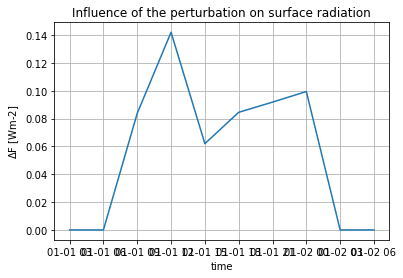

In [2]:
INFILE = xr.open_dataset(os.path.join(infile_path,
                                      infile_fname.format(date=date)))

OUTF = re.get_ecrad_ds(ifile=INFILE,
                       outfile = False,
                       reduce_out = True,
                       perturbation=[],
                       aerosol=True,
                       h2o_scale=1,
                       o3_scale=1,
                       co2_scale=1,
                       time=False,
                       ecrad_path = os.path.join(ecrad_path,'bin/'),
                       opfile = aerosol_props,
                       debug=False)

## perturb mass extinction by +5%
# OUT_perturbed = re.get_ecrad_ds(ifile=INFILE,
#                        outfile = False,
#                        reduce_out = True,
#                        perturbation=[('mass_ext_sw_hydrophilic',((slice(None),slice(None),slice(None)),5.)),
#                                     ('mass_ext_sw_hydrophobic',((slice(None),slice(None)),5.)),
#                                     ('mass_ext_mono_hydrophilic',((slice(None),slice(None),slice(None)),5.)),
#                                     ('mass_ext_mono_hydrophobic',((slice(None),slice(None)),5.))
#                                     ],
#                        aerosol=True,
#                        h2o_scale=1,
#                        o3_scale=1,
#                        co2_scale=1,
#                        time=False,
#                        ecrad_path = os.path.join(ecrad_path,'bin/'),
#                        opfile = aerosol_props,
#                        debug=False)

## perturb AE by +5%
import AE_perturbation as perturbeAE
perturbation = perturbeAE.perturbe_AE(OPfile=os.path.join(ecrad_path,'data/',aerosol_props),
                                      pert=5)
OUT_perturbed = re.get_ecrad_ds(ifile=INFILE,
                       outfile = False,
                       reduce_out = True,
                       perturbation=perturbation,
                       aerosol=True,
                       h2o_scale=1,
                       o3_scale=1,
                       co2_scale=1,
                       time=False,
                       ecrad_path = os.path.join(ecrad_path,'bin/'),
                       opfile = aerosol_props,
                       debug=False)


## convert to cams grid coordinates
time = INFILE.time
lat = INFILE.latitude
lon  = INFILE.longitude

lvlshape = (len(np.unique(time)),
            len(np.unique(lat)),
            len(np.unique(lon)))
newshape = (lvlshape[0],
            lvlshape[1],
            lvlshape[2])

# unperturbed surface irradiance
F = np.zeros(newshape)
F[:,:,:] = OUTF.flux_dn_sw_sfc.values[:].reshape(lvlshape)

# perturbed surface irradaince
F_perturbed = np.zeros(newshape)
F_perturbed[:,:,:] = OUT_perturbed.flux_dn_sw_sfc.values.reshape(lvlshape)

# plot the result
plt.title('Influence of the perturbation on surface radiation')
plt.plot(np.unique(time)[:10],F_perturbed[:10,0,0]-F[:10,0,0])
plt.grid(True)
plt.xlabel('time')
plt.ylabel(r'$\Delta$F [Wm-2]')

In [21]:
perturbeAE.pertube_AE

<function AE_perturbation.pertube_AE(OPfile, pert)>